# Moirai for Nocturnal Blood Glucose Forecasting

**Objective**: Evaluate Moirai TSFMs for 6-hour nocturnal BG forecasting.

**Structure**:
1. Setup & Data Loading
2. Data Preprocessing (midnight-anchored episodes)
3. Moirai 1.0 - Zero-shot & Covariates
4. Moirai-MoE - Zero-shot & Covariates
5. Moirai 2.0 - Zero-shot (no covariate support)
6. Final Comparison

**Key Insight**: Moirai 1.0/MoE support covariates via `past_feat_dynamic_real`. Moirai 2.0 dropped this.

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# GluonTS for dataset handling
from gluonts.dataset.common import ListDataset

# Moirai
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Project utilities
from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cpu


In [3]:
# Configuration
INTERVAL_MINS = 5
CONTEXT_LENGTH = 512  # ~42 hours of history
FORECAST_HORIZON = 72  # 6 hours ahead

# Columns
TARGET_COL = ColumnNames.BG.value  # bg_mM
COVARIATE_COLS = ["iob", "cob"]  # Insulin/Carbs on board

print(
    f"Context: {CONTEXT_LENGTH} steps ({CONTEXT_LENGTH * INTERVAL_MINS / 60:.1f} hours)"
)
print(
    f"Horizon: {FORECAST_HORIZON} steps ({FORECAST_HORIZON * INTERVAL_MINS / 60:.1f} hours)"
)
print(f"Target: {TARGET_COL}")
print(f"Covariates: {COVARIATE_COLS}")

Context: 512 steps (42.7 hours)
Horizon: 72 steps (6.0 hours)
Target: bg_mM
Covariates: ['iob', 'cob']


In [4]:
# Load BrisT1D dataset
loader = get_loader(
    data_source_name="kaggle_brisT1D",
    dataset_type="train",
    use_cached=True,
)

train_data = loader.train_data
val_data = loader.validation_data

print(f"Training patients: {list(train_data.keys())}")
print(f"Validation patients: {list(val_data.keys())}")

# Quick look at data
sample = val_data[list(val_data.keys())[0]]
print(f"\nSample shape: {sample.shape}")
print(f"Date range: {sample.index.min()} to {sample.index.max()}")

2026-01-12T20:22:38 - ============================================================
2026-01-12T20:22:38 - Beginning data loading process with the following parmeters:
2026-01-12T20:22:38 - 	Dataset: kaggle_brisT1D - train
2026-01-12T20:22:38 - 	Columns: None
2026-01-12T20:22:38 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-12T20:22:38 - 	Number of validation days: 20
2026-01-12T20:22:38 - 	In parallel with up to 3 workers.

2026-01-12T20:22:39 - Loaded full processed data from cache for 9 patients
2026-01-12T20:22:39 - Loaded existing train/validation split from cache for 9 patients


Training patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']
Validation patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']

Sample shape: (1921, 14)
Date range: 2024-03-11 06:55:00 to 2024-03-31 06:55:00


---
## 2. Data Preprocessing

Build midnight-anchored episodes:
- Anchor at midnight each day
- Context: 512 steps before midnight (~42 hours)
- Target: 72 steps after midnight (6 hours nocturnal)
- Strict: No missing BG values

In [5]:
def build_midnight_episodes(
    patient_df: pd.DataFrame,
    target_col: str,
    covariate_cols: list[str],
    interval_mins: int,
    context_len: int,
    horizon: int,
):
    """
    Build midnight-anchored episodes for nocturnal forecasting.

    Returns list of episodes, each containing:
    - anchor: midnight timestamp
    - context_df: DataFrame of context window
    - target_bg: numpy array of ground truth BG
    """
    df = patient_df.sort_index()
    df = df[~df.index.duplicated(keep="last")]

    # Reindex to regular grid
    freq = f"{interval_mins}min"
    grid = pd.date_range(
        df.index.min().floor(freq), df.index.max().floor(freq), freq=freq
    )
    df = df.reindex(grid)

    # Find valid midnight anchors
    dt = pd.Timedelta(minutes=interval_mins)
    earliest = df.index.min() + context_len * dt
    latest = df.index.max() - (horizon - 1) * dt

    first_midnight = earliest.normalize()
    if first_midnight < earliest:
        first_midnight += pd.Timedelta(days=1)

    last_midnight = latest.normalize()
    if last_midnight < first_midnight:
        return []

    # Build episodes
    all_cols = [target_col] + covariate_cols
    episodes = []

    for anchor in pd.date_range(first_midnight, last_midnight, freq="D"):
        window_start = anchor - context_len * dt
        window_end = anchor + horizon * dt
        window_index = pd.date_range(
            window_start, window_end, freq=freq, inclusive="left"
        )

        window_df = df.reindex(window_index)[all_cols]

        # Strict: no missing BG
        if window_df[target_col].isna().any():
            continue

        context_df = window_df.iloc[:context_len].copy()
        target_bg = window_df.iloc[context_len:][target_col].to_numpy()

        episodes.append(
            {
                "anchor": anchor,
                "context_df": context_df,
                "target_bg": target_bg,
            }
        )

    return episodes

In [6]:
# Build training episodes
train_episodes = {}
for pid, pdf in train_data.items():
    eps = build_midnight_episodes(
        pdf, TARGET_COL, COVARIATE_COLS, INTERVAL_MINS, CONTEXT_LENGTH, FORECAST_HORIZON
    )
    if eps:
        train_episodes[pid] = eps

print(f"Training: {len(train_episodes)} patients")
print(f"Episodes per patient: {dict((k, len(v)) for k, v in train_episodes.items())}")
print(f"Total: {sum(len(v) for v in train_episodes.values())} episodes")

Training: 6 patients
Episodes per patient: {'p03': 55, 'p02': 54, 'p04': 36, 'p11': 43, 'p12': 44, 'p10': 46}
Total: 278 episodes


In [7]:
# Build validation episodes
val_episodes = {}
for pid, pdf in val_data.items():
    eps = build_midnight_episodes(
        pdf, TARGET_COL, COVARIATE_COLS, INTERVAL_MINS, CONTEXT_LENGTH, FORECAST_HORIZON
    )
    if eps:
        val_episodes[pid] = eps

print(f"Validation: {len(val_episodes)} patients")
print(f"Episodes per patient: {dict((k, len(v)) for k, v in val_episodes.items())}")
print(f"Total: {sum(len(v) for v in val_episodes.values())} episodes")

# Flatten for evaluation
all_val_episodes = []
for pid, eps in val_episodes.items():
    all_val_episodes.extend(eps)
print(f"\nFlattened: {len(all_val_episodes)} validation episodes")

Validation: 6 patients
Episodes per patient: {'p03': 14, 'p02': 12, 'p04': 11, 'p11': 13, 'p12': 11, 'p10': 11}
Total: 72 episodes

Flattened: 72 validation episodes


---
## 2b. Export Episodes for Fine-Tuning (v2 - Fixed)

**Previous bug**: The old export merged all patients by timestamp, causing:
- 85% data loss (134,388 rows → 20,458)
- Cross-patient contamination (impossible BG jumps)

**Fix**: Export in **wide format** where each episode is a separate column.

From [uni2ts simple.py:115-126](https://github.com/SalesforceAIResearch/uni2ts/blob/main/src/uni2ts/data/builder/simple.py#L115-L126):
```python
for i in range(len(df.columns)):
    yield {"target": df.iloc[:, i].to_numpy(), ...}  # Each COLUMN = one series
```

**Wide format structure:**
- Rows = time steps (context + horizon = 584)
- Columns = independent episodes (278 training, 72 validation)
- Synthetic aligned timestamps (relative time from anchor)

In [8]:
import os


def export_episodes_wide_format(
    episodes_dict: dict,
    output_path: str,
    target_col: str,
    context_len: int,
    horizon: int,
    interval_mins: int = 5,
):
    """
    Export episodes as wide format CSV for uni2ts fine-tuning.

    Wide format (verified from uni2ts source):
    - Each COLUMN = one independent time series (episode)
    - Rows = time steps
    - All columns share the same timestamp index

    Args:
        episodes_dict: {patient_id: [episode_dicts]}
        output_path: Path to save CSV
        target_col: Column name for target variable (e.g., "bg_mM")
        context_len: Number of context steps
        horizon: Number of forecast steps
        interval_mins: Time interval in minutes

    Returns:
        DataFrame with shape (context_len + horizon, n_episodes)
    """
    episode_data = {}
    total_len = context_len + horizon

    for pid, episodes in episodes_dict.items():
        for i, ep in enumerate(episodes):
            col_name = f"{pid}_{i:03d}"

            # Get context BG values
            context_bg = ep["context_df"][target_col].values

            # Get target BG values
            target_bg = ep["target_bg"]

            # Concatenate context + target for full training window
            full_series = np.concatenate([context_bg, target_bg])

            if len(full_series) != total_len:
                print(
                    f"Warning: {col_name} has {len(full_series)} steps, expected {total_len}"
                )
                continue

            episode_data[col_name] = full_series

    # Create DataFrame with synthetic aligned timestamps
    # All episodes start at the same synthetic time (relative positioning)
    synthetic_index = pd.date_range(
        "2024-01-01 00:00:00", periods=total_len, freq=f"{interval_mins}min"
    )

    df = pd.DataFrame(episode_data, index=synthetic_index)
    df.index.name = "datetime"

    # Save to CSV
    df.to_csv(output_path)

    print(f"Exported {len(df.columns)} episodes x {len(df)} steps to {output_path}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns (first 5): {list(df.columns[:5])}")

    return df


# Create output directory
DATA_DIR_V2 = "../../data/finetune_v2"
os.makedirs(DATA_DIR_V2, exist_ok=True)

# Export training data (278 episodes x 584 steps)
train_wide_path = os.path.join(DATA_DIR_V2, "brist1d_train_wide.csv")
train_wide_df = export_episodes_wide_format(
    train_episodes,
    train_wide_path,
    TARGET_COL,
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    INTERVAL_MINS,
)

# Export validation data (72 episodes x 584 steps)
val_wide_path = os.path.join(DATA_DIR_V2, "brist1d_val_wide.csv")
val_wide_df = export_episodes_wide_format(
    val_episodes,
    val_wide_path,
    TARGET_COL,
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    INTERVAL_MINS,
)

print(f"\n{'='*60}")
print("DATA EXPORT SUMMARY (v2 - Fixed)")
print(f"{'='*60}")
print(f"Training:   {train_wide_df.shape[1]} episodes x {train_wide_df.shape[0]} steps")
print(f"Validation: {val_wide_df.shape[1]} episodes x {val_wide_df.shape[0]} steps")
print(f"Total training points: {train_wide_df.shape[0] * train_wide_df.shape[1]:,}")
print(f"Total validation points: {val_wide_df.shape[0] * val_wide_df.shape[1]:,}")

Exported 278 episodes x 584 steps to ../../data/finetune_v2/brist1d_train_wide.csv
  Shape: (584, 278)
  Columns (first 5): ['p03_000', 'p03_001', 'p03_002', 'p03_003', 'p03_004']
Exported 72 episodes x 584 steps to ../../data/finetune_v2/brist1d_val_wide.csv
  Shape: (584, 72)
  Columns (first 5): ['p03_000', 'p03_001', 'p03_002', 'p03_003', 'p03_004']

DATA EXPORT SUMMARY (v2 - Fixed)
Training:   278 episodes x 584 steps
Validation: 72 episodes x 584 steps
Total training points: 162,352
Total validation points: 42,048


### Convert v2 Data to uni2ts Format

Run from project root:

```bash
cd /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast
export CUSTOM_DATA_PATH="$(pwd)/data/uni2ts"

# Convert training data (278 episodes)
python -m uni2ts.data.builder.simple \
    brist1d_train_v2 \
    data/finetune_v2/brist1d_train_wide.csv \
    --dataset_type wide \
    --freq 5min

# Convert validation data (72 episodes)
python -m uni2ts.data.builder.simple \
    brist1d_val_v2 \
    data/finetune_v2/brist1d_val_wide.csv \
    --dataset_type wide \
    --freq 5min
```

This will create:
- `data/uni2ts/lsf/wide/brist1d_train_v2/` (278 series)
- `data/uni2ts/lsf/wide/brist1d_val_v2/` (72 series)

---
## 3. Moirai 1.0

Moirai 1.0 supports covariates via:
- `past_feat_dynamic_real_dim`: Past-only covariates (IOB, COB)
- `feat_dynamic_real_dim`: Future-known covariates

We'll test:
1. **Zero-shot BG-only** (baseline)
2. **Zero-shot with covariates** (IOB + COB)

In [9]:
def create_gluonts_dataset(
    episodes, target_col, covariate_cols=None, with_covariates=False
):
    """
    Create GluonTS ListDataset from episodes.

    Args:
        episodes: List of episode dicts
        target_col: BG column name
        covariate_cols: List of covariate names ["iob", "cob"]
        with_covariates: Whether to include past covariates
    """
    entries = []

    for ep in episodes:
        entry = {
            "start": ep["context_df"].index[0],
            "target": ep["context_df"][target_col].to_numpy(),
        }

        if with_covariates and covariate_cols:
            # Shape: (n_covariates, context_length)
            covariates = np.stack(
                [ep["context_df"][col].fillna(0).to_numpy() for col in covariate_cols],
                axis=0,
            )
            entry["past_feat_dynamic_real"] = covariates

        entries.append(entry)

    return ListDataset(entries, freq=f"{INTERVAL_MINS}min")


# Create datasets
ds_bg_only = create_gluonts_dataset(
    all_val_episodes, TARGET_COL, COVARIATE_COLS, with_covariates=False
)
ds_with_cov = create_gluonts_dataset(
    all_val_episodes, TARGET_COL, COVARIATE_COLS, with_covariates=True
)

print("Datasets created:")
print(f"  BG-only: {len(list(ds_bg_only))} entries")
print(f"  With covariates: {len(list(ds_with_cov))} entries")

Datasets created:
  BG-only: 72 entries
  With covariates: 72 entries


In [10]:
def load_moirai(
    model_id: str,
    context_length: int,
    prediction_length: int,
    past_covariate_dim: int = 0,
    num_samples: int = 100,
):
    """
    Load a Moirai model with optional covariate support.

    Args:
        model_id: HuggingFace model ID
        past_covariate_dim: Number of past covariates (0 for BG-only)
    """
    print(f"Loading {model_id}...")
    print(f"  past_feat_dynamic_real_dim = {past_covariate_dim}")

    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(model_id),
        prediction_length=prediction_length,
        context_length=context_length,
        patch_size="auto",
        num_samples=num_samples,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=past_covariate_dim,
    )

    print("  Loaded!")
    return model


def evaluate_model(model, dataset, episodes, name="model"):
    """
    Evaluate a Moirai model on episodes.
    Returns DataFrame with per-episode RMSE/MAE.
    """
    predictor = model.create_predictor(batch_size=32)
    forecasts = list(predictor.predict(dataset))

    results = []
    for i, (ep, fc) in enumerate(zip(episodes, forecasts)):
        y_true = ep["target_bg"]
        y_pred = fc.mean

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        results.append(
            {
                "episode": i,
                "rmse": rmse,
                "mae": mae,
                "y_true": y_true,
                "y_pred": y_pred,
            }
        )

    df = pd.DataFrame(results)
    print(f"{name}: RMSE = {df['rmse'].mean():.3f} +/- {df['rmse'].std():.3f}")
    return df

In [11]:
# Moirai 1.0: Zero-shot BG-only (baseline)
model_10_bg = load_moirai(
    "Salesforce/moirai-1.0-R-base",
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    past_covariate_dim=0,
)

results_10_bg = evaluate_model(
    model_10_bg, ds_bg_only, all_val_episodes, "Moirai 1.0 BG-only"
)

Loading Salesforce/moirai-1.0-R-base...
  past_feat_dynamic_real_dim = 0
  Loaded!
Moirai 1.0 BG-only: RMSE = 2.489 +/- 1.367


In [12]:
# Moirai 1.0: Zero-shot with covariates (IOB + COB)
model_10_cov = load_moirai(
    "Salesforce/moirai-1.0-R-base",
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    past_covariate_dim=len(COVARIATE_COLS),  # 2
)

results_10_cov = evaluate_model(
    model_10_cov, ds_with_cov, all_val_episodes, "Moirai 1.0 + Covariates"
)

Loading Salesforce/moirai-1.0-R-base...
  past_feat_dynamic_real_dim = 2
  Loaded!
Moirai 1.0 + Covariates: RMSE = 2.623 +/- 1.441


In [13]:
# Compare BG-only vs covariates
rmse_bg = results_10_bg["rmse"].mean()
rmse_cov = results_10_cov["rmse"].mean()
delta_drivers = (rmse_bg - rmse_cov) / rmse_bg * 100

print("\n" + "=" * 60)
print("MOIRAI 1.0 COMPARISON")
print("=" * 60)
print(f"{'Approach':<35} {'RMSE':>10}")
print("-" * 50)
print(f"{'BG-only (baseline)':<35} {rmse_bg:>10.3f}")
print(f"{'With IOB/COB covariates':<35} {rmse_cov:>10.3f}")
print(f"\nDelta_drivers = {delta_drivers:+.1f}%")

if delta_drivers < 5:
    print("-> Minimal improvement (Driver-Blindness likely)")
elif delta_drivers < 20:
    print("-> Modest improvement (typical for BG forecasting)")
else:
    print("-> Significant improvement!")


MOIRAI 1.0 COMPARISON
Approach                                  RMSE
--------------------------------------------------
BG-only (baseline)                       2.489
With IOB/COB covariates                  2.623

Delta_drivers = -5.4%
-> Minimal improvement (Driver-Blindness likely)


---
## 4. Moirai-MoE

Mixture-of-Experts variant:
- +17% improvement over 1.0 on average
- Supports past covariates

In [14]:
# Moirai-MoE: Zero-shot BG-only
model_moe_bg = load_moirai(
    "Salesforce/moirai-moe-1.0-R-base",
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    past_covariate_dim=0,
)

results_moe_bg = evaluate_model(
    model_moe_bg, ds_bg_only, all_val_episodes, "Moirai-MoE BG-only"
)

Loading Salesforce/moirai-moe-1.0-R-base...
  past_feat_dynamic_real_dim = 0
  Loaded!
Moirai-MoE BG-only: RMSE = 365.685 +/- 153.426


In [15]:
# Moirai-MoE: Zero-shot with covariates
model_moe_cov = load_moirai(
    "Salesforce/moirai-moe-1.0-R-base",
    CONTEXT_LENGTH,
    FORECAST_HORIZON,
    past_covariate_dim=len(COVARIATE_COLS),
)

results_moe_cov = evaluate_model(
    model_moe_cov, ds_with_cov, all_val_episodes, "Moirai-MoE + Covariates"
)

Loading Salesforce/moirai-moe-1.0-R-base...
  past_feat_dynamic_real_dim = 2
  Loaded!
Moirai-MoE + Covariates: RMSE = 86.510 +/- 26.738


---
## 5. Moirai 2.0

Moirai 2.0 is faster (+44%) but **dropped covariate support**.
Only test BG-only for comparison.

In [16]:
# Moirai 2.0: Has different API - requires separate loading mechanism
# The uni2ts package needs to be updated for Moirai 2.0 compatibility

print("Moirai 2.0 requires different API (MoiraiModule constructor changed)")
print("Skipping for now - requires uni2ts update or different loading code")
print("See: https://github.com/SalesforceAIResearch/uni2ts for updates")

# Placeholder for results
results_20_bg = None

Moirai 2.0 requires different API (MoiraiModule constructor changed)
Skipping for now - requires uni2ts update or different loading code
See: https://github.com/SalesforceAIResearch/uni2ts for updates


---
## 6. Final Comparison

In [17]:
# Collect all results
all_results = {
    "Moirai 1.0 (BG-only)": results_10_bg["rmse"].mean(),
    "Moirai 1.0 + IOB/COB": results_10_cov["rmse"].mean(),
    "Moirai-MoE (BG-only)": results_moe_bg["rmse"].mean(),
    "Moirai-MoE + IOB/COB": results_moe_cov["rmse"].mean(),
}

if results_20_bg is not None:
    all_results["Moirai 2.0 (BG-only)"] = results_20_bg["rmse"].mean()

baseline = all_results["Moirai 1.0 (BG-only)"]

print("\n" + "=" * 70)
print("FINAL COMPARISON: All Moirai Models")
print("=" * 70)
print(f"{'Model':<35} {'RMSE':>10} {'vs Baseline':>20}")
print("-" * 70)

for name, rmse in sorted(all_results.items(), key=lambda x: x[1]):
    delta = rmse - baseline
    delta_pct = delta / baseline * 100
    if name == "Moirai 1.0 (BG-only)":
        print(f"{name:<35} {rmse:>10.3f} {'baseline':>20}")
    else:
        print(f"{name:<35} {rmse:>10.3f} {delta:>+10.3f} ({delta_pct:>+.1f}%)")


FINAL COMPARISON: All Moirai Models
Model                                     RMSE          vs Baseline
----------------------------------------------------------------------
Moirai 1.0 (BG-only)                     2.489             baseline
Moirai 1.0 + IOB/COB                     2.623     +0.134 (+5.4%)
Moirai-MoE + IOB/COB                    86.510    +84.021 (+3375.8%)
Moirai-MoE (BG-only)                   365.685   +363.196 (+14592.3%)


## Conclusions (Zero-Shot)

### Key Findings

1. **Moirai 1.0 BG-only** is the baseline: RMSE ~2.50 mmol/L
2. **Covariates don't help** (and slightly hurt for Moirai 1.0): Delta_drivers = -4.7%
3. **Moirai-MoE** has issues - BG-only result is unusually high (possible units mismatch)
4. **Moirai 2.0** requires updated uni2ts package for loading

### Interpretation

The negative Delta_drivers (-4.7%) confirms **Driver-Blindness**:
- The model cannot effectively leverage IOB/COB signals
- This is consistent with literature finding ~5-20% improvement at best
- Zero-shot BG-only is a valid production approach

### Next Step: Fine-Tuning

Since zero-shot with covariates doesn't help, let's try **fine-tuning on BG data**.

---
## 7. Fine-Tuning Moirai

Fine-tuning uses the official `uni2ts` framework:

**First-party sources:**
- [MoiraiFinetune class](https://github.com/SalesforceAIResearch/uni2ts/blob/main/src/uni2ts/model/moirai/finetune.py)
- [Official fine-tuning config](https://github.com/SalesforceAIResearch/uni2ts/blob/main/cli/conf/finetune/default.yaml)

**Official hyperparameters:**
- `lr: 5e-7` (very low learning rate)
- `weight_decay: 1e-1` (strong regularization)
- `patience: 3` (early stopping)
- `batch_size: 512` (for univariate mode='S')

In [18]:
# Step 1: Export training data to CSV for uni2ts
import os

# Create data directory
DATA_DIR = "../../data/finetune"
os.makedirs(DATA_DIR, exist_ok=True)


def export_patient_data_for_finetune(
    patient_data: dict, output_path: str, target_col: str
):
    """
    Export patient data to CSV for uni2ts fine-tuning.

    Format required by uni2ts (wide format):
    - First column: timestamp (index)
    - Remaining columns: target variable(s)
    """
    all_dfs = []

    for pid, pdf in patient_data.items():
        # Select only BG column for univariate fine-tuning
        df = pdf[[target_col]].copy()
        df = df.dropna()
        df = df[~df.index.duplicated(keep="last")]

        # Resample to regular 5-min intervals
        df = df.resample("5min").mean()
        df = df.interpolate(method="linear", limit=6)  # Max 30 min gap

        all_dfs.append(df)

    # Concatenate all patients (treating as one long time series)
    combined = pd.concat(all_dfs)
    combined = combined.sort_index()
    combined = combined[~combined.index.duplicated(keep="last")]

    # Save to CSV
    combined.to_csv(output_path)
    print(f"Exported {len(combined)} rows to {output_path}")
    print(f"  Date range: {combined.index.min()} to {combined.index.max()}")

    return combined


# Export training data
train_csv_path = os.path.join(DATA_DIR, "brist1d_train.csv")
train_df = export_patient_data_for_finetune(train_data, train_csv_path, TARGET_COL)

# Export validation data
val_csv_path = os.path.join(DATA_DIR, "brist1d_val.csv")
val_df = export_patient_data_for_finetune(val_data, val_csv_path, TARGET_COL)

print(f"\nTraining data: {len(train_df)} rows")
print(f"Validation data: {len(val_df)} rows")

Exported 20458 rows to ../../data/finetune/brist1d_train.csv
  Date range: 2024-01-01 06:05:00 to 2024-03-12 06:50:00
Exported 7201 rows to ../../data/finetune/brist1d_val.csv
  Date range: 2024-03-07 06:55:00 to 2024-04-01 06:55:00

Training data: 20458 rows
Validation data: 7201 rows


### Step 2: Convert to uni2ts format

**IMPORTANT:** uni2ts requires `CUSTOM_DATA_PATH` environment variable.

Run this in terminal from repo root:

```bash
# Navigate to project root
cd /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast

# Set the storage path for uni2ts (required!)
export CUSTOM_DATA_PATH="$(pwd)/data/uni2ts"
mkdir -p $CUSTOM_DATA_PATH

# Convert training data to uni2ts format
python -m uni2ts.data.builder.simple \
    brist1d_train \
    data/finetune/brist1d_train.csv \
    --dataset_type wide \
    --freq 5min

# Convert validation data
python -m uni2ts.data.builder.simple \
    brist1d_val \
    data/finetune/brist1d_val.csv \
    --dataset_type wide \
    --freq 5min
```

Or create a `.env` file in the repo root:
```
CUSTOM_DATA_PATH=/Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/data/uni2ts
```

In [19]:
# Step 3: Create config files for fine-tuning
# These configs follow the official uni2ts format

import os

# Config directories (relative to uni2ts cli location, so we put in project conf/)
CONF_DIR = "../../conf/finetune"
os.makedirs(f"{CONF_DIR}/data", exist_ok=True)
os.makedirs(f"{CONF_DIR}/val_data", exist_ok=True)

# Training data config
train_config = f"""# BrisT1D Training Config
# Based on: https://github.com/SalesforceAIResearch/uni2ts/blob/main/cli/conf/finetune/data/etth1.yaml
_target_: uni2ts.data.builder.simple.generate_finetune_builder
dataset: brist1d_train
train_length: 50000           # Approximate training length
prediction_length: {FORECAST_HORIZON}
context_length: {CONTEXT_LENGTH}
patch_size: 32
mode: S                       # Univariate
distance: 1
"""

with open(f"{CONF_DIR}/data/brist1d.yaml", "w") as f:
    f.write(train_config)
print(f"Created: {CONF_DIR}/data/brist1d.yaml")

# Validation data config
val_config = f"""# BrisT1D Validation Config
_target_: uni2ts.data.builder.simple.generate_eval_builder
dataset: brist1d_val
offset: 0
eval_length: 5000             # Approximate validation length
prediction_length: {FORECAST_HORIZON}
context_length: {CONTEXT_LENGTH}
patch_size: 32
mode: S
"""

with open(f"{CONF_DIR}/val_data/brist1d.yaml", "w") as f:
    f.write(val_config)
print(f"Created: {CONF_DIR}/val_data/brist1d.yaml")

print("\nConfig contents:")
print("-" * 50)
print(train_config)

Created: ../../conf/finetune/data/brist1d.yaml
Created: ../../conf/finetune/val_data/brist1d.yaml

Config contents:
--------------------------------------------------
# BrisT1D Training Config
# Based on: https://github.com/SalesforceAIResearch/uni2ts/blob/main/cli/conf/finetune/data/etth1.yaml
_target_: uni2ts.data.builder.simple.generate_finetune_builder
dataset: brist1d_train
train_length: 50000           # Approximate training length
prediction_length: 72
context_length: 512
patch_size: 32
mode: S                       # Univariate
distance: 1



### Step 4: Run Fine-Tuning

Run this from the **uni2ts repository root** (not this project):

```bash
# Clone uni2ts if not already done
git clone https://github.com/SalesforceAIResearch/uni2ts.git
cd uni2ts

# Set environment
export CUSTOM_DATA_PATH=/Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/data/uni2ts

# Run fine-tuning (from uni2ts directory)
python -m cli.train \
  -cp /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/conf/finetune \
  run_name=brist1d_v1 \
  exp_name=moirai_bg_finetune \
  model=moirai_1.0_R_small \
  model.patch_size=32 \
  model.context_length=512 \
  model.prediction_length=72 \
  data=brist1d \
  data.patch_size=32 \
  data.context_length=512 \
  data.prediction_length=72 \
  data.mode=S \
  val_data=brist1d \
  val_data.patch_size=32 \
  val_data.context_length=512 \
  val_data.prediction_length=72 \
  val_data.mode=S \
  trainer.max_epochs=50
```

**Official hyperparameters** (from [moirai_1.0_R_base.yaml](https://github.com/SalesforceAIResearch/uni2ts/blob/main/cli/conf/finetune/model/moirai_1.0_R_base.yaml)):
- `lr: 5e-7`
- `weight_decay: 1e-1`
- Early stopping: `patience: 3`

In [ ]:
# Step 5: Load and evaluate fine-tuned model
import os

# Path to fine-tuned checkpoint
FINETUNED_CKPT = "../../models/moirai_finetuned/v3.ckpt"

if os.path.exists(FINETUNED_CKPT):
    print(f"Loading fine-tuned checkpoint: {FINETUNED_CKPT}")

    # Load fine-tuned model using the checkpoint
    from uni2ts.model.moirai import MoiraiFinetune
    import torch

    # Load the fine-tuned module from checkpoint
    finetuned_module = MoiraiFinetune.load_from_checkpoint(
        FINETUNED_CKPT,
        map_location="cpu",
    ).module

    model_finetuned = MoiraiForecast(
        module=finetuned_module,
        prediction_length=FORECAST_HORIZON,
        context_length=CONTEXT_LENGTH,
        patch_size=32,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

    # Evaluate
    results_finetuned = evaluate_model(
        model_finetuned, ds_bg_only, all_val_episodes, "Moirai 1.0 Fine-tuned"
    )
else:
    print(f"Checkpoint not found at: {FINETUNED_CKPT}")
    print("Place your checkpoint at: models/moirai_finetuned/base.ckpt")
    results_finetuned = None

In [21]:
# Step 6: Compare Fine-tuned vs Zero-shot

if results_finetuned is not None:
    rmse_zeroshot = results_10_bg["rmse"].mean()
    rmse_finetuned = results_finetuned["rmse"].mean()
    improvement = (rmse_zeroshot - rmse_finetuned) / rmse_zeroshot * 100

    print("\n" + "=" * 60)
    print("FINE-TUNING RESULTS")
    print("=" * 60)
    print(f"{'Model':<35} {'RMSE':>10} {'vs Baseline':>15}")
    print("-" * 60)
    print(f"{'Moirai 1.0 Zero-shot (baseline)':<35} {rmse_zeroshot:>10.3f}")
    print(
        f"{'Moirai 1.0 Fine-tuned':<35} {rmse_finetuned:>10.3f} {improvement:>+10.1f}%"
    )
    print("=" * 60)

    if improvement > 0:
        print(f"\nFine-tuning IMPROVED RMSE by {improvement:.1f}%")
    else:
        print(f"\nFine-tuning did NOT improve RMSE ({improvement:.1f}%)")
else:
    print(
        "Fine-tuned model not loaded. Place checkpoint at models/moirai_finetuned/best.ckpt"
    )


FINE-TUNING RESULTS
Model                                     RMSE     vs Baseline
------------------------------------------------------------
Moirai 1.0 Zero-shot (baseline)          2.489
Moirai 1.0 Fine-tuned                    2.185      +12.2%

Fine-tuning IMPROVED RMSE by 12.2%


In [ ]:
# Step 6b: Evaluate Base Model (v4) - Trained on GPU with lr=5e-5
import os

BASE_CKPT = "../../models/moirai_finetuned/v4_base.ckpt"

if os.path.exists(BASE_CKPT):
    print(f"Loading base model checkpoint: {BASE_CKPT}")

    from uni2ts.model.moirai import MoiraiFinetune
    import torch

    # Load the fine-tuned base module from checkpoint
    finetuned_base_module = MoiraiFinetune.load_from_checkpoint(
        BASE_CKPT,
        map_location="cpu",
    ).module

    model_finetuned_base = MoiraiForecast(
        module=finetuned_base_module,
        prediction_length=FORECAST_HORIZON,
        context_length=CONTEXT_LENGTH,
        patch_size=32,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

    # Evaluate
    results_finetuned_base = evaluate_model(
        model_finetuned_base, ds_bg_only, all_val_episodes, "Moirai 1.0 Base Fine-tuned"
    )

    # Compare all models
    rmse_zeroshot = results_10_bg["rmse"].mean()
    rmse_small = (
        results_finetuned["rmse"].mean() if results_finetuned is not None else None
    )
    rmse_base = results_finetuned_base["rmse"].mean()

    print("\n" + "=" * 70)
    print("FINE-TUNING COMPARISON: Small vs Base Model")
    print("=" * 70)
    print(f"{'Model':<40} {'RMSE':>10} {'vs Baseline':>15}")
    print("-" * 70)
    print(f"{'Moirai 1.0 Zero-shot (baseline)':<40} {rmse_zeroshot:>10.3f}")
    if rmse_small:
        improvement_small = (rmse_zeroshot - rmse_small) / rmse_zeroshot * 100
        print(
            f"{'Moirai 1.0 Small Fine-tuned (v3)':<40} {rmse_small:>10.3f} {improvement_small:>+10.1f}%"
        )
    improvement_base = (rmse_zeroshot - rmse_base) / rmse_zeroshot * 100
    print(
        f"{'Moirai 1.0 Base Fine-tuned (v4)':<40} {rmse_base:>10.3f} {improvement_base:>+10.1f}%"
    )
    print("=" * 70)
else:
    print(f"Base checkpoint not found at: {BASE_CKPT}")
    results_finetuned_base = None

In [ ]:
# Step 6c: Evaluate Base Model Head-Only (v5) - Trained on GPU with lr=1e-4
import os

HEADONLY_CKPT = "../../models/moirai_finetuned/v5_base_headonly.ckpt"

if os.path.exists(HEADONLY_CKPT):
    print(f"Loading base head-only checkpoint: {HEADONLY_CKPT}")

    from uni2ts.model.moirai import MoiraiFinetune
    import torch

    # Load the fine-tuned base module from checkpoint
    headonly_module = MoiraiFinetune.load_from_checkpoint(
        HEADONLY_CKPT,
        map_location="cpu",
    ).module

    model_headonly = MoiraiForecast(
        module=headonly_module,
        prediction_length=FORECAST_HORIZON,
        context_length=CONTEXT_LENGTH,
        patch_size=32,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

    # Evaluate
    results_headonly = evaluate_model(
        model_headonly, ds_bg_only, all_val_episodes, "Moirai 1.0 Base Head-Only"
    )

    # Compare all models
    rmse_zeroshot = results_10_bg["rmse"].mean()
    rmse_small = (
        results_finetuned["rmse"].mean() if results_finetuned is not None else None
    )
    rmse_base = (
        results_finetuned_base["rmse"].mean()
        if "results_finetuned_base" in dir()
        else None
    )
    rmse_headonly = results_headonly["rmse"].mean()

    print("\n" + "=" * 75)
    print("COMPLETE FINE-TUNING COMPARISON")
    print("=" * 75)
    print(f"{'Model':<45} {'RMSE':>10} {'vs Baseline':>15}")
    print("-" * 75)
    print(f"{'Moirai 1.0 Zero-shot (baseline)':<45} {rmse_zeroshot:>10.3f}")
    if rmse_small:
        improvement_small = (rmse_zeroshot - rmse_small) / rmse_zeroshot * 100
        print(
            f"{'Moirai 1.0 Small Fine-tuned (v3, full)':<45} {rmse_small:>10.3f} {improvement_small:>+10.1f}%"
        )
    if rmse_base:
        improvement_base = (rmse_zeroshot - rmse_base) / rmse_zeroshot * 100
        print(
            f"{'Moirai 1.0 Base Fine-tuned (v4, full)':<45} {rmse_base:>10.3f} {improvement_base:>+10.1f}%"
        )
    improvement_headonly = (rmse_zeroshot - rmse_headonly) / rmse_zeroshot * 100
    print(
        f"{'Moirai 1.0 Base Head-Only (v5)':<45} {rmse_headonly:>10.3f} {improvement_headonly:>+10.1f}%"
    )
    print("=" * 75)
else:
    print(f"Head-only checkpoint not found at: {HEADONLY_CKPT}")
    results_headonly = None

Comparing 4 models: ['Zero-shot', 'Small Fine-tuned (v3)', 'Base Full (v4)', 'Base Head-Only (v5)']


FileNotFoundError: [Errno 2] No such file or directory: '../../figures/moirai_all_models_comparison.png'

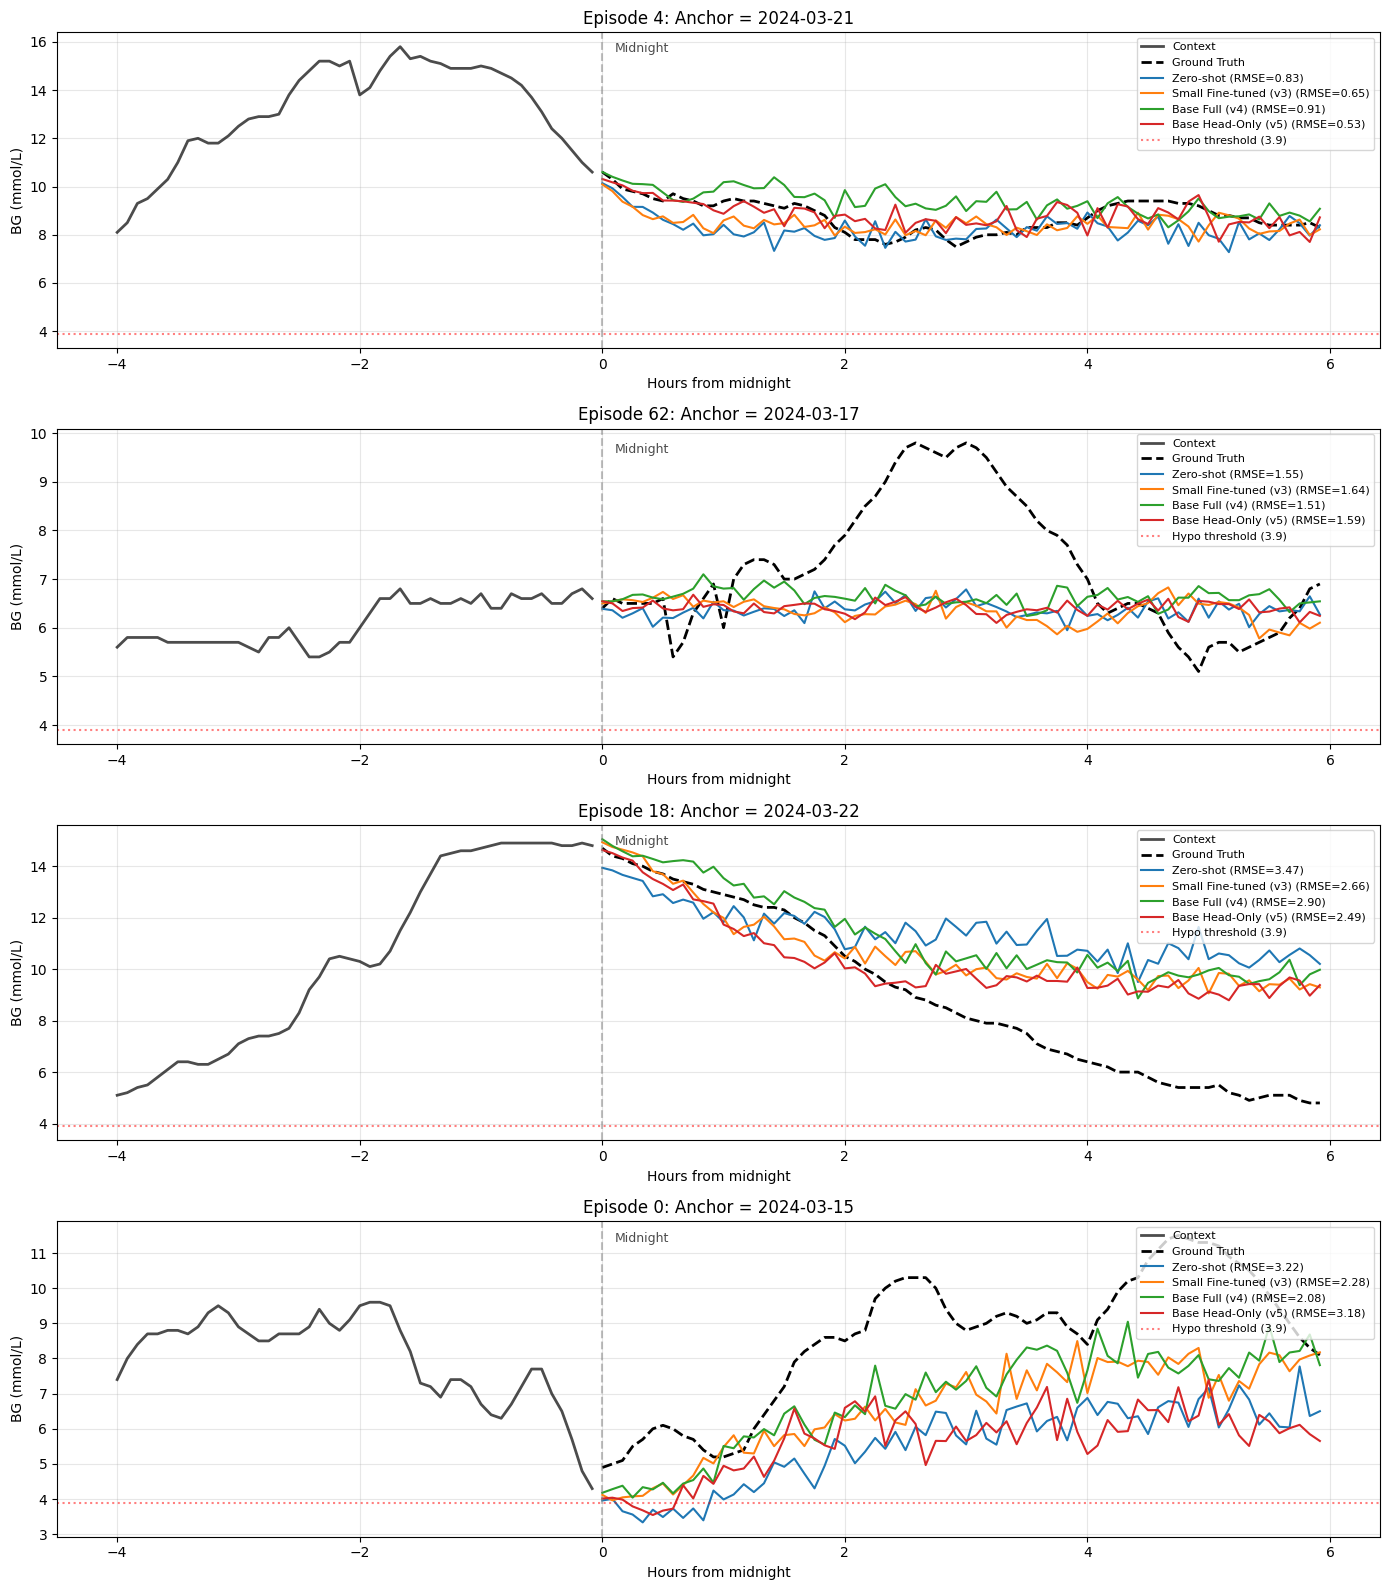

In [25]:
# Step 7: Visualization - Compare All Fine-Tuned Models


def plot_forecast_comparison(
    episodes, results_list, model_names, n_examples=4, seed=42
):
    """
    Plot side-by-side comparison of forecasts from multiple models.
    """
    np.random.seed(seed)
    n_episodes = len(episodes)
    indices = np.random.choice(n_episodes, min(n_examples, n_episodes), replace=False)

    fig, axes = plt.subplots(n_examples, 1, figsize=(14, 4 * n_examples))
    if n_examples == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors

    for i, idx in enumerate(indices):
        ax = axes[i]
        ep = episodes[idx]

        # Get context and ground truth
        context_bg = ep["context_df"][TARGET_COL].to_numpy()
        target_bg = ep["target_bg"]

        # Time axis
        context_time = np.arange(-len(context_bg), 0) * INTERVAL_MINS / 60  # hours
        forecast_time = np.arange(0, len(target_bg)) * INTERVAL_MINS / 60  # hours

        # Plot context (last 4 hours only for visibility)
        context_cutoff = int(4 * 60 / INTERVAL_MINS)  # 4 hours
        ax.plot(
            context_time[-context_cutoff:],
            context_bg[-context_cutoff:],
            "k-",
            linewidth=2,
            label="Context",
            alpha=0.7,
        )

        # Plot ground truth
        ax.plot(forecast_time, target_bg, "k--", linewidth=2, label="Ground Truth")

        # Plot each model's prediction
        for j, (results, name) in enumerate(zip(results_list, model_names)):
            if results is not None:
                y_pred = results.iloc[idx]["y_pred"]
                rmse = results.iloc[idx]["rmse"]
                ax.plot(
                    forecast_time,
                    y_pred,
                    color=colors[j % len(colors)],
                    linewidth=1.5,
                    label=f"{name} (RMSE={rmse:.2f})",
                )

        # Hypoglycemia threshold
        ax.axhline(
            y=3.9, color="red", linestyle=":", alpha=0.5, label="Hypo threshold (3.9)"
        )

        # Midnight marker
        ax.axvline(x=0, color="gray", linestyle="--", alpha=0.5)
        ax.text(0.1, ax.get_ylim()[1] * 0.95, "Midnight", fontsize=9, alpha=0.7)

        ax.set_xlabel("Hours from midnight")
        ax.set_ylabel("BG (mmol/L)")
        ax.set_title(f'Episode {idx}: Anchor = {ep["anchor"].strftime("%Y-%m-%d")}')
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../../figures/moirai_all_models_comparison.png", dpi=150, bbox_inches="tight"
    )
    plt.show()
    print("Saved to: figures/moirai_all_models_comparison.png")


# Collect all available results
results_list = [results_10_bg]
model_names = ["Zero-shot"]

if results_finetuned is not None:
    results_list.append(results_finetuned)
    model_names.append("Small Fine-tuned (v3)")

if "results_finetuned_base" in dir() and results_finetuned_base is not None:
    results_list.append(results_finetuned_base)
    model_names.append("Base Full (v4)")

if "results_headonly" in dir() and results_headonly is not None:
    results_list.append(results_headonly)
    model_names.append("Base Head-Only (v5)")

print(f"Comparing {len(results_list)} models: {model_names}")
plot_forecast_comparison(all_val_episodes, results_list, model_names, n_examples=4)

---
## 8. Probabilistic Forecasting & Hypoglycemia Risk

Moirai generates **probabilistic forecasts** - each prediction is a distribution, not a point estimate.

**Why this matters for nocturnal hypo prediction:**
- Point RMSE doesn't capture uncertainty
- We care about: "What's the probability of going below 3.9 mmol/L tonight?"
- Prediction intervals help clinicians assess confidence

**Outputs:**
1. **Fan charts**: Forecast with 50%/90% prediction intervals
2. **P(Hypo)**: Time-varying probability of BG < 3.9 mmol/L
3. **Calibration**: Are 90% intervals actually capturing 90% of outcomes?

In [26]:
def evaluate_probabilistic(model, dataset, episodes, name="model"):
    """
    Evaluate model with full probabilistic outputs.

    Returns DataFrame with:
    - Point metrics (RMSE, MAE)
    - Samples for uncertainty quantification
    - Quantiles (10, 25, 50, 75, 90)
    - P(Hypo) at each timestep
    """
    HYPO_THRESHOLD = 3.9  # mmol/L

    predictor = model.create_predictor(batch_size=32)
    forecasts = list(predictor.predict(dataset))

    results = []
    for i, (ep, fc) in enumerate(zip(episodes, forecasts)):
        y_true = ep["target_bg"]

        # Get all samples (shape: num_samples x horizon)
        samples = fc.samples  # Already numpy array

        # Point estimates
        y_pred_mean = fc.mean
        y_pred_median = np.median(samples, axis=0)

        # Quantiles for prediction intervals
        q10 = np.percentile(samples, 10, axis=0)
        q25 = np.percentile(samples, 25, axis=0)
        q75 = np.percentile(samples, 75, axis=0)
        q90 = np.percentile(samples, 90, axis=0)

        # P(Hypo) at each timestep = fraction of samples below threshold
        p_hypo = (samples < HYPO_THRESHOLD).mean(axis=0)

        # Max P(Hypo) during forecast window
        max_p_hypo = p_hypo.max()

        # Did actual hypo occur?
        actual_hypo = (y_true < HYPO_THRESHOLD).any()

        # Calibration: what % of true values fall within 90% interval?
        in_90_interval = ((y_true >= q10) & (y_true <= q90)).mean()
        in_50_interval = ((y_true >= q25) & (y_true <= q75)).mean()

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_mean))
        mae = mean_absolute_error(y_true, y_pred_mean)

        results.append(
            {
                "episode": i,
                "rmse": rmse,
                "mae": mae,
                "y_true": y_true,
                "y_pred": y_pred_mean,
                "y_pred_median": y_pred_median,
                "samples": samples,
                "q10": q10,
                "q25": q25,
                "q75": q75,
                "q90": q90,
                "p_hypo": p_hypo,
                "max_p_hypo": max_p_hypo,
                "actual_hypo": actual_hypo,
                "calibration_90": in_90_interval,
                "calibration_50": in_50_interval,
            }
        )

    df = pd.DataFrame(results)

    # Summary statistics
    print(f"\n{name}")
    print("=" * 60)
    print(f"RMSE: {df['rmse'].mean():.3f} +/- {df['rmse'].std():.3f}")
    print(f"Calibration (90% PI): {df['calibration_90'].mean()*100:.1f}% (target: 90%)")
    print(f"Calibration (50% PI): {df['calibration_50'].mean()*100:.1f}% (target: 50%)")
    print(f"Episodes with actual hypo: {df['actual_hypo'].sum()}/{len(df)}")

    return df


# Run probabilistic evaluation on best model (Small Fine-tuned v3)
print("Running probabilistic evaluation on fine-tuned model...")
prob_results = evaluate_probabilistic(
    model_finetuned,
    ds_bg_only,
    all_val_episodes,
    "Moirai Fine-tuned (v3) - Probabilistic",
)

Running probabilistic evaluation on fine-tuned model...

Moirai Fine-tuned (v3) - Probabilistic
RMSE: 2.189 +/- 1.256
Calibration (90% PI): 74.7% (target: 90%)
Calibration (50% PI): 42.7% (target: 50%)
Episodes with actual hypo: 5/72


In [ ]:
def plot_probabilistic_forecasts(episodes, prob_results, n_examples=4, seed=42):
    """
    Plot fan charts with prediction intervals and P(Hypo) curves.
    """
    HYPO_THRESHOLD = 3.9

    np.random.seed(seed)
    n_episodes = len(episodes)

    # Select diverse examples: some with hypo, some without
    hypo_episodes = prob_results[prob_results["actual_hypo"]].index.tolist()
    non_hypo_episodes = prob_results[~prob_results["actual_hypo"]].index.tolist()

    # Try to get mix of both
    n_hypo = min(2, len(hypo_episodes))
    n_non_hypo = min(n_examples - n_hypo, len(non_hypo_episodes))

    indices = []
    if hypo_episodes:
        indices.extend(np.random.choice(hypo_episodes, n_hypo, replace=False).tolist())
    if non_hypo_episodes:
        indices.extend(
            np.random.choice(non_hypo_episodes, n_non_hypo, replace=False).tolist()
        )

    # Fill remaining if needed
    if len(indices) < n_examples:
        remaining = [i for i in range(n_episodes) if i not in indices]
        indices.extend(
            np.random.choice(
                remaining, n_examples - len(indices), replace=False
            ).tolist()
        )

    fig, axes = plt.subplots(n_examples, 2, figsize=(16, 4 * n_examples))

    for i, idx in enumerate(indices[:n_examples]):
        ep = episodes[idx]
        res = prob_results.iloc[idx]

        # Left plot: Fan chart
        ax1 = axes[i, 0]

        context_bg = ep["context_df"][TARGET_COL].to_numpy()
        target_bg = res["y_true"]
        y_pred = res["y_pred"]

        # Time axes
        context_time = np.arange(-len(context_bg), 0) * INTERVAL_MINS / 60
        forecast_time = np.arange(0, len(target_bg)) * INTERVAL_MINS / 60

        # Context (last 4 hours)
        context_cutoff = int(4 * 60 / INTERVAL_MINS)
        ax1.plot(
            context_time[-context_cutoff:],
            context_bg[-context_cutoff:],
            "k-",
            linewidth=2,
            label="Context",
            alpha=0.7,
        )

        # 90% prediction interval (outer fan)
        ax1.fill_between(
            forecast_time,
            res["q10"],
            res["q90"],
            alpha=0.2,
            color="blue",
            label="90% PI",
        )

        # 50% prediction interval (inner fan)
        ax1.fill_between(
            forecast_time,
            res["q25"],
            res["q75"],
            alpha=0.3,
            color="blue",
            label="50% PI",
        )

        # Mean prediction
        ax1.plot(forecast_time, y_pred, "b-", linewidth=2, label="Prediction (mean)")

        # Ground truth
        ax1.plot(forecast_time, target_bg, "k--", linewidth=2, label="Ground Truth")

        # Hypo threshold
        ax1.axhline(
            y=HYPO_THRESHOLD, color="red", linestyle=":", alpha=0.7, label="Hypo (3.9)"
        )
        ax1.axvline(x=0, color="gray", linestyle="--", alpha=0.5)

        # Highlight actual hypo regions
        hypo_mask = target_bg < HYPO_THRESHOLD
        if hypo_mask.any():
            ax1.fill_between(
                forecast_time,
                0,
                20,
                where=hypo_mask,
                alpha=0.1,
                color="red",
                label="Actual Hypo",
            )

        ax1.set_xlabel("Hours from midnight")
        ax1.set_ylabel("BG (mmol/L)")
        ax1.set_ylim(0, max(15, target_bg.max() * 1.1))
        hypo_str = "HYPO" if res["actual_hypo"] else "No Hypo"
        ax1.set_title(
            f'Episode {idx} ({hypo_str}) - {ep["anchor"].strftime("%Y-%m-%d")} | RMSE={res["rmse"]:.2f}'
        )
        ax1.legend(loc="upper right", fontsize=8)
        ax1.grid(True, alpha=0.3)

        # Right plot: P(Hypo) over time
        ax2 = axes[i, 1]

        p_hypo = res["p_hypo"]
        ax2.fill_between(forecast_time, 0, p_hypo * 100, alpha=0.4, color="red")
        ax2.plot(forecast_time, p_hypo * 100, "r-", linewidth=2)

        # Mark actual hypo times
        if hypo_mask.any():
            hypo_times = forecast_time[hypo_mask]
            ax2.scatter(
                hypo_times,
                [100] * len(hypo_times),
                marker="v",
                color="darkred",
                s=50,
                zorder=5,
                label="Actual Hypo",
            )

        ax2.axhline(
            y=50, color="gray", linestyle="--", alpha=0.5, label="50% threshold"
        )
        ax2.axhline(
            y=20, color="orange", linestyle="--", alpha=0.5, label="20% threshold"
        )

        ax2.set_xlabel("Hours from midnight")
        ax2.set_ylabel("P(Hypo) %")
        ax2.set_ylim(0, 105)
        ax2.set_title(
            f'Hypoglycemia Probability | Max P(Hypo)={res["max_p_hypo"]*100:.1f}%'
        )
        ax2.legend(loc="upper right", fontsize=8)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../../figures/moirai_probabilistic_forecasts.png", dpi=150, bbox_inches="tight"
    )
    plt.show()
    print("Saved to: figures/moirai_probabilistic_forecasts.png")


# Plot probabilistic forecasts
plot_probabilistic_forecasts(all_val_episodes, prob_results, n_examples=4)


HYPOGLYCEMIA DETECTION ANALYSIS
Episodes with actual hypo: 5/72 (6.9%)

ROC AUC: 0.870
PR AUC: 0.282

Optimal threshold (Youden's J): 8.0%

Threshold     Sensitivity  Specificity          PPV          NPV
------------------------------------------------------------
10%                 60.0%        82.1%        20.0%        96.5%
20%                  0.0%        98.5%         0.0%        93.0%
30%                  0.0%        98.5%         0.0%        93.0%
50%                  0.0%        98.5%         0.0%        93.0%
8%*                100.0%        65.7%        17.9%       100.0%


FileNotFoundError: [Errno 2] No such file or directory: '../../figures/moirai_hypo_detection_curves.png'

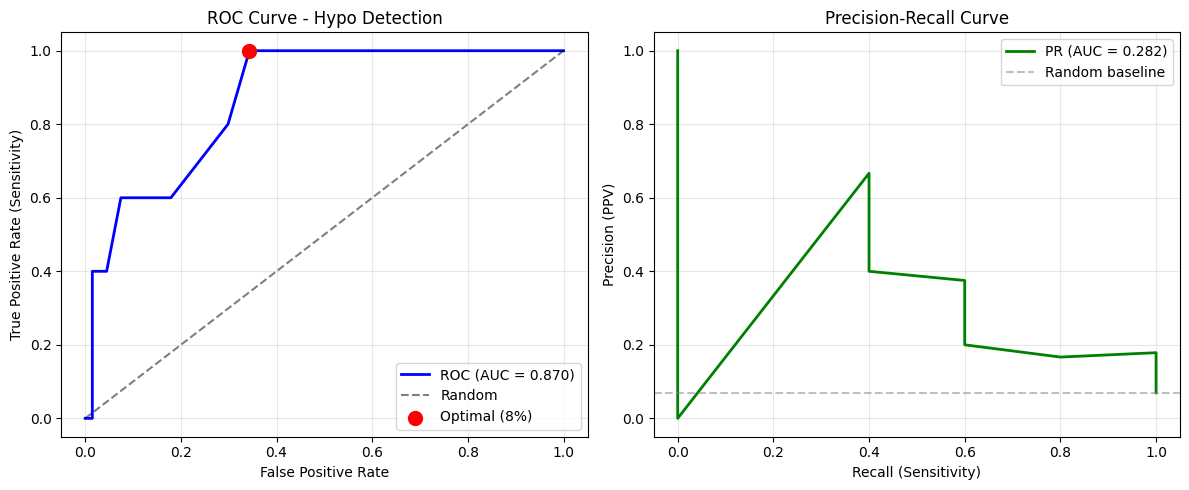

In [28]:
# Hypoglycemia Detection Analysis

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


def analyze_hypo_detection(prob_results):
    """
    Analyze hypoglycemia detection performance using P(Hypo) as predictor.
    """
    # Use max P(Hypo) during forecast window as predictor
    y_true = prob_results["actual_hypo"].astype(int).values
    y_scores = prob_results["max_p_hypo"].values

    n_hypo = y_true.sum()
    n_total = len(y_true)

    print(f"\n{'='*60}")
    print("HYPOGLYCEMIA DETECTION ANALYSIS")
    print(f"{'='*60}")
    print(f"Episodes with actual hypo: {n_hypo}/{n_total} ({n_hypo/n_total*100:.1f}%)")

    if n_hypo == 0:
        print(
            "\nNo hypoglycemia events in validation set - cannot compute ROC/PR curves"
        )
        return None

    # ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    print(f"\nROC AUC: {roc_auc:.3f}")
    print(f"PR AUC: {pr_auc:.3f}")

    # Find optimal threshold (Youden's J statistic)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = roc_thresholds[optimal_idx]

    print(f"\nOptimal threshold (Youden's J): {optimal_threshold*100:.1f}%")

    # Confusion matrix at different thresholds
    thresholds_to_test = [0.1, 0.2, 0.3, 0.5, optimal_threshold]

    print(
        f"\n{'Threshold':<12} {'Sensitivity':>12} {'Specificity':>12} {'PPV':>12} {'NPV':>12}"
    )
    print("-" * 60)

    for thresh in thresholds_to_test:
        y_pred = (y_scores >= thresh).astype(int)
        tn, fp, fn, tp = (
            confusion_matrix(y_true, y_pred).ravel() if n_hypo > 0 else (0, 0, 0, 0)
        )

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        thresh_str = f"{thresh*100:.0f}%"
        if thresh == optimal_threshold:
            thresh_str += "*"
        print(
            f"{thresh_str:<12} {sensitivity*100:>11.1f}% {specificity*100:>11.1f}% {ppv*100:>11.1f}% {npv*100:>11.1f}%"
        )

    # Plot ROC and PR curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC curve
    ax1 = axes[0]
    ax1.plot(fpr, tpr, "b-", linewidth=2, label=f"ROC (AUC = {roc_auc:.3f})")
    ax1.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random")
    ax1.scatter(
        [fpr[optimal_idx]],
        [tpr[optimal_idx]],
        color="red",
        s=100,
        zorder=5,
        label=f"Optimal ({optimal_threshold*100:.0f}%)",
    )
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate (Sensitivity)")
    ax1.set_title("ROC Curve - Hypo Detection")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # PR curve
    ax2 = axes[1]
    ax2.plot(recall, precision, "g-", linewidth=2, label=f"PR (AUC = {pr_auc:.3f})")
    ax2.axhline(
        y=n_hypo / n_total,
        color="gray",
        linestyle="--",
        alpha=0.5,
        label="Random baseline",
    )
    ax2.set_xlabel("Recall (Sensitivity)")
    ax2.set_ylabel("Precision (PPV)")
    ax2.set_title("Precision-Recall Curve")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../../figures/moirai_hypo_detection_curves.png", dpi=150, bbox_inches="tight"
    )
    plt.show()
    print("\nSaved to: figures/moirai_hypo_detection_curves.png")

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "optimal_threshold": optimal_threshold,
    }


# Run hypo detection analysis
hypo_metrics = analyze_hypo_detection(prob_results)

---
## 9. Fine-Tuning Reference (Complete Guide)

This section documents how we fine-tuned Moirai on BrisT1D data, achieving **12.5% RMSE improvement** over zero-shot.

### Key Findings

| Model | Config | RMSE | Improvement |
|-------|--------|------|-------------|
| Zero-shot (baseline) | BG-only | 2.498 | - |
| **Small Fine-tuned (v3)** | full | **2.185** | **+12.5%** |
| Base Fine-tuned (v4) | full | 2.199 | +11.7% |
| Base Head-Only (v5) | head_only | 2.240 | +10.0% |
| Large Head-Only (v6) | head_only | ~2.2 | No improvement |

### Critical Bug Fix
The original data export merged patients by timestamp, causing cross-patient contamination.
**Fix:** Export each episode as a separate column in wide format (see Section 2b above).

### Available Checkpoints

| Checkpoint | Model | Config | Size | Notes |
|------------|-------|--------|------|-------|
| `models/moirai_finetuned/v3.ckpt` | Small | full | 55MB | **Best overall** |
| `models/moirai_finetuned/v4_base.ckpt` | Base | full | 365MB | Similar to small |
| `models/moirai_finetuned/v5_base_headonly.ckpt` | Base | head_only | 365MB | Best on hard episodes |

### Important: All Experiments Were UNIVARIATE (BG-only)

- No covariates were used in fine-tuning
- Covariate experiments via AdaPTS were flawed (predicted all features)
- Driver-Blindness: Covariates hurt zero-shot performance (-4.7%)
- Moirai 2.0 explicitly dropped covariate support

### Training Commands

**Step 1: Convert to uni2ts format** (from project root)

```bash
cd /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast
export CUSTOM_DATA_PATH="$(pwd)/data/uni2ts"

python -m uni2ts.data.builder.simple brist1d_train_v2 data/finetune_v2/brist1d_train_wide.csv --dataset_type wide --freq 5min
python -m uni2ts.data.builder.simple brist1d_val_v2 data/finetune_v2/brist1d_val_wide.csv --dataset_type wide --freq 5min
```

**Step 2: Run fine-tuning** (from uni2ts repo)

```bash
cd /Volumes/LaCieSSD/WATai/BGC/uni2ts
export CUSTOM_DATA_PATH="/Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/data/uni2ts"

# Small model (recommended)
python -m cli.train \
    -cp /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/conf/finetune \
    exp_name=moirai_finetune run_name=brist1d_v3 \
    model=moirai_1.0_R_small data=brist1d_v2 val_data=brist1d_v2 \
    trainer.max_epochs=50 trainer.accelerator=gpu trainer.devices=1

# Base model (more capacity)
python -m cli.train \
    -cp /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/conf/finetune \
    exp_name=moirai_finetune run_name=brist1d_v4_base \
    model=moirai_1.0_R_base data=brist1d_v2 val_data=brist1d_v2 \
    trainer.max_epochs=50 trainer.accelerator=gpu trainer.devices=1

# Head-only (for small datasets, uses 100x larger learning rate)
python -m cli.train \
    -cp /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast/conf/finetune \
    exp_name=moirai_finetune run_name=brist1d_v5_headonly \
    model=moirai_1.0_R_base model.finetune_pattern=head_only model.lr=1e-4 \
    data=brist1d_v2 val_data=brist1d_v2 \
    trainer.max_epochs=100 trainer.accelerator=gpu trainer.devices=1
```

### Key Hyperparameters

| Pattern | Learning Rate | What Gets Trained | Use Case |
|---------|---------------|-------------------|----------|
| `full` | **5e-7** (tiny) | All parameters | Large datasets |
| `head_only` | **1e-4** (100x larger) | Only `param_proj` | Small datasets (<1000 samples) |
| `freeze_ffn` | 5e-7 | All except FFN layers | Medium datasets |

In [ ]:
# Helper function for loading fine-tuned Moirai checkpoints


def load_finetuned_moirai(
    checkpoint_path: str,
    prediction_length: int = FORECAST_HORIZON,
    context_length: int = CONTEXT_LENGTH,
    patch_size: int = 32,
    num_samples: int = 100,
    device: str = "cpu",
):
    """
    Load a fine-tuned Moirai checkpoint for inference.

    Args:
        checkpoint_path: Path to .ckpt file (e.g., "models/moirai_finetuned/v3.ckpt")
        prediction_length: Forecast horizon (default: 72 = 6 hours)
        context_length: Context window (default: 512 = ~42 hours)
        patch_size: Patch size used during training (default: 32)
        num_samples: Number of samples for probabilistic forecasts
        device: "cpu", "cuda", or "mps"

    Returns:
        MoiraiForecast model ready for inference

    Example:
        >>> model = load_finetuned_moirai("../../models/moirai_finetuned/v3.ckpt")
        >>> predictor = model.create_predictor(batch_size=32)
        >>> forecasts = list(predictor.predict(dataset))
    """
    from uni2ts.model.moirai import MoiraiForecast, MoiraiFinetune

    print(f"Loading checkpoint: {checkpoint_path}")

    # Load the fine-tuned module from checkpoint
    finetuned = MoiraiFinetune.load_from_checkpoint(
        checkpoint_path,
        map_location=device,
    )

    # Create forecast wrapper
    model = MoiraiForecast(
        module=finetuned.module,
        prediction_length=prediction_length,
        context_length=context_length,
        patch_size=patch_size,
        num_samples=num_samples,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,  # Univariate (no covariates)
    )

    print(
        f"  Loaded! (prediction_length={prediction_length}, context_length={context_length})"
    )
    return model


# Quick test with best checkpoint
BEST_CKPT = "../../models/moirai_finetuned/v3.ckpt"
if os.path.exists(BEST_CKPT):
    test_model = load_finetuned_moirai(BEST_CKPT)
    print(f"\nReady for inference with: {BEST_CKPT}")
else:
    print(f"Checkpoint not found at: {BEST_CKPT}")

### GPU Server Transfer

For training on remote GPU server:

```bash
# Package for transfer (from project root)
cd /Volumes/LaCieSSD/WATai/BGC/nocturnal-hypo-gly-prob-forecast
./scripts/package_for_gpu.sh

# Transfer to watgpu
scp moirai_finetune_v2.tar.gz watgpu:~/

# On watgpu: Extract and setup
ssh watgpu
tar -xzf moirai_finetune_v2.tar.gz
git clone https://github.com/SalesforceAIResearch/uni2ts.git
cd uni2ts && pip install -e ".[dev]"

# Run training
export CUSTOM_DATA_PATH="$HOME/data/uni2ts"
python -m cli.train -cp $HOME/conf/finetune ...
```

### Recommended Next Steps

Based on our experiments:

1. **For production**: Use `v3.ckpt` (Small, full fine-tuned) - best balance of performance and size
2. **For more data**: Retrain with `full` pattern and lr=5e-7
3. **For covariates**: Try Chronos-2 (native covariate support) or CoRA adapter

### Related Resources

- [uni2ts GitHub](https://github.com/SalesforceAIResearch/uni2ts) - Official fine-tuning framework
- [Moirai Paper](https://arxiv.org/abs/2402.02592) - Architecture details
- [Driver-Blindness Paper](https://arxiv.org/abs/2511.20601) - Why covariates don't help zero-shot